# Time Series Forecasting for deciding investment for Jet Rail

### Load Packages

In [1]:
import pandas as pd          
import numpy as np          
import matplotlib.pyplot as plt  
from datetime import datetime    
from pandas import Series        
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, Holt
import math

### Import dataset and make a copy

In [2]:
train=pd.read_csv("Train_SU63ISt.csv")
test=pd.read_csv("Test_0qrQsBZ.csv")

train_original=train.copy()
test_original=test.copy()

### Data Structure and Content

In [3]:
train.shape

(18288, 3)

In [4]:
test.shape

(5112, 2)

In [5]:
train.columns 

Index(['ID', 'Datetime', 'Count'], dtype='object')

In [6]:
test.columns

Index(['ID', 'Datetime'], dtype='object')

In [7]:
train.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [8]:
test.dtypes

ID           int64
Datetime    object
dtype: object

###  Change Datetime format

In [9]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

### Explotarory data analysis

#### Introduce individual colums for year, month, day and hour

In [10]:
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour

#### Introduce column for weekend for analysis

In [11]:
train['day of week']=train['Datetime'].dt.dayofweek
temp = train['Datetime']

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

temp2 = train['Datetime'].apply(applyer)
train['weekend']=temp2

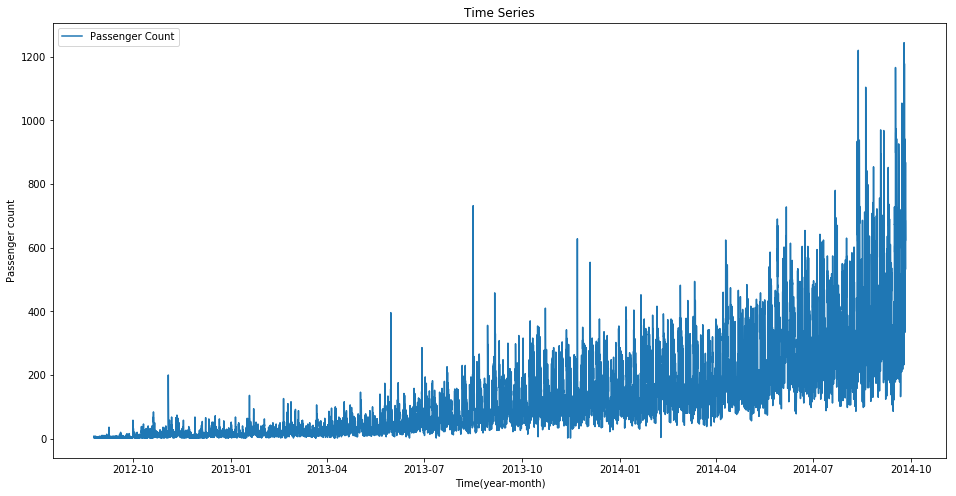

In [12]:
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis.
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis.
ts = df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

#### Plot of mean passenger count for years, months, days, weekend

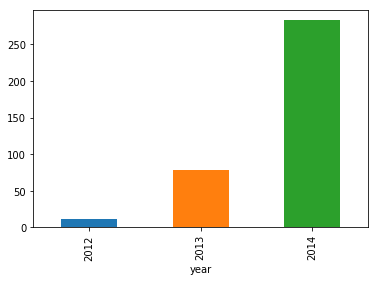

In [13]:
train.groupby('year')['Count'].mean().plot.bar()

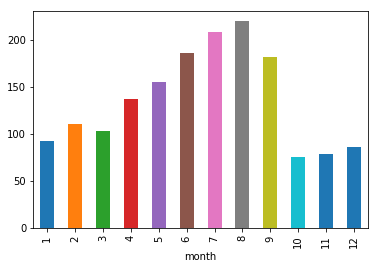

In [14]:
train.groupby('month')['Count'].mean().plot.bar()

Oct(10), Nov(11), Dec(12) have low values because of unavailibilty of data for these months for year 2014. Therefore, this plot doesn't provide much insight.

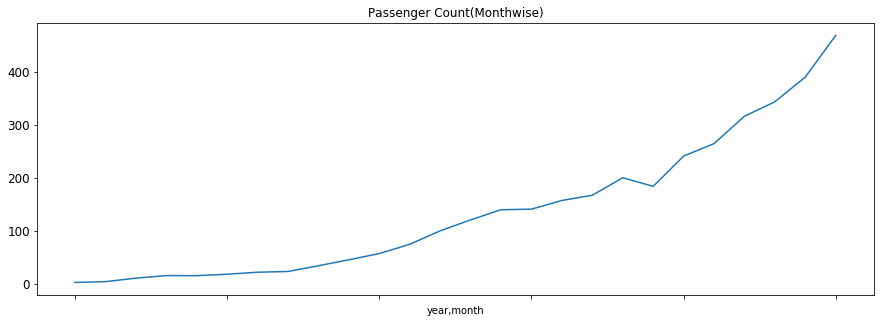

In [15]:
temp=train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=12)

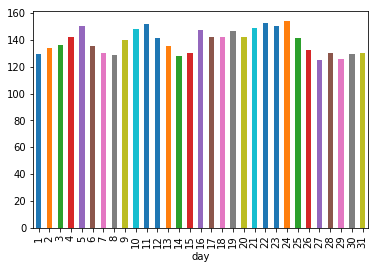

In [16]:
train.groupby('day')['Count'].mean().plot.bar()

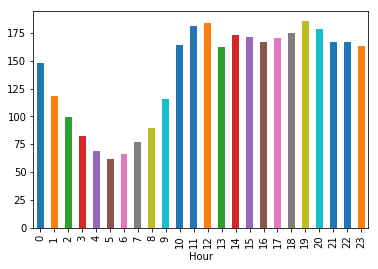

In [17]:
train.groupby('Hour')['Count'].mean().plot.bar()

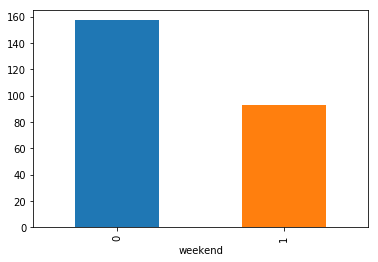

In [18]:
train.groupby('weekend')['Count'].mean().plot.bar()

0 represents weekday and 1 represents weekend

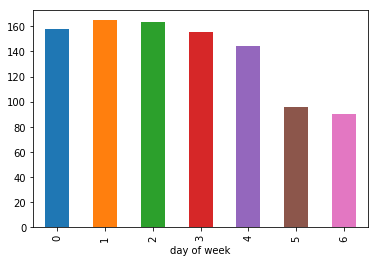

In [19]:
train.groupby('day of week')['Count'].mean().plot.bar()

0 - Mon, 1 - Tue, 2 - Wed, 3 - Thu, 4- Fri, 5 - Sat, 6 - Sun

### Dropping unwanted column

In [20]:
# dropping ID as it's not required
train=train.drop('ID',1)

###  Visualizing hourly, daily, weekly and monthly mean

/Users/karneshjain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


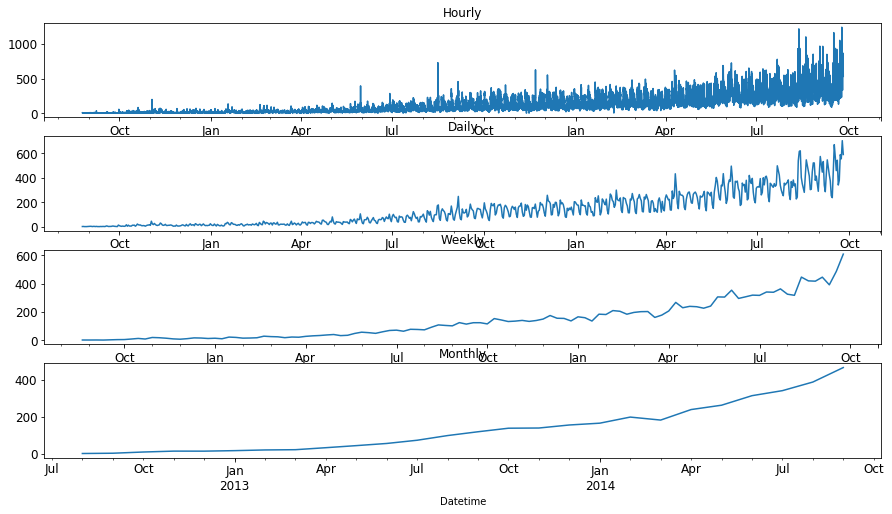

In [21]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Hourly time series
hourly = train.resample('H').mean()

# Converting to daily mean
daily = train.resample('D').mean()

# Converting to weekly mean
weekly = train.resample('W').mean()

# Converting to monthly mean
monthly = train.resample('M').mean()

fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=12, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=12, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=12, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=12, ax=axs[3])

plt.show()

##### We will work with daily average because working with weekly or monthly average would require lot of conversions to get the hourly values.

### Getting the daily mean

In [22]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 

# Converting to daily mean
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Converting to daily mean
train = train.resample('D').mean()

/Users/karneshjain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


### Train and Validation split based on Timestamp

In [23]:
Train=train.ix['2012-08-25':'2014-06-24']
valid=train.ix['2014-06-25':'2014-09-25']

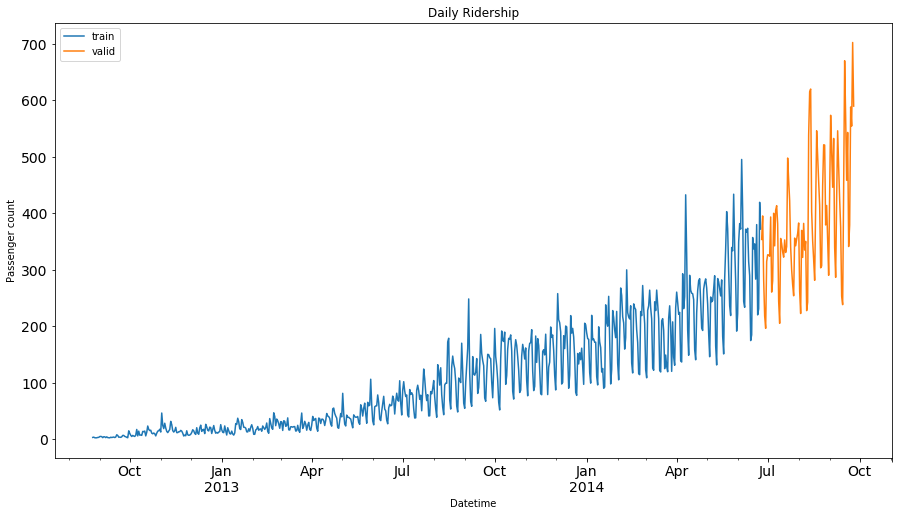

In [24]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

## Holt Winter's Model

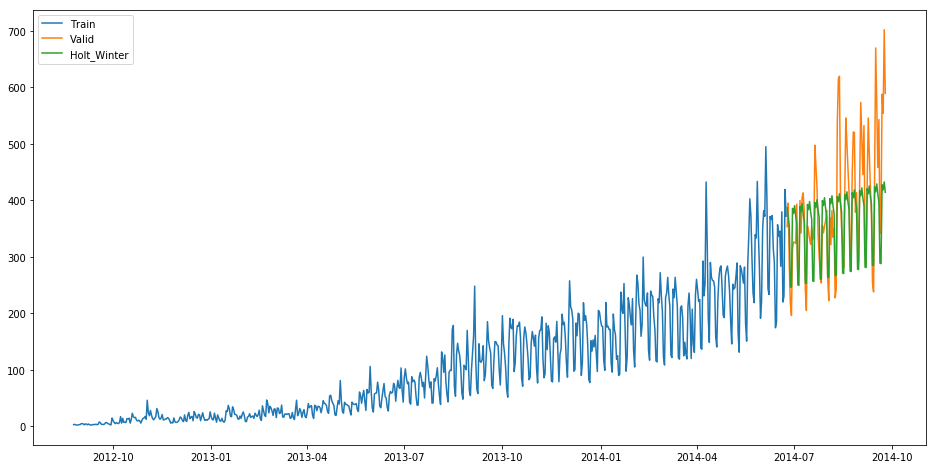

In [25]:
y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot( Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [26]:
rms = math.sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter))
print(rms)

82.37527095912128


### Make prediction

In [27]:
predict=fit1.forecast(len(test))

In [28]:
test['prediction']=predict

#### Convert to hourly passenger count

In [29]:
# Calculating the hourly ratio of count
train_original['ratio']=train_original['Count']/train_original['Count'].sum()
    
# Grouping the hourly ratio
temp=train_original.groupby(['Hour'])['ratio'].sum()
    
# Groupby to csv format
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv')
    
temp2=pd.read_csv("GROUPby.csv")
temp2=temp2.drop('Hour.1',1)

In [30]:
# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)
    
# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')
    
# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y']

In [31]:
# drop unwanted columns from predicted data
prediction = prediction.drop(['ID_x', 'day', 'ID_y','prediction', 'ratio'],axis=1)

In [32]:
test.head()

,ID,year,month,day,Hour,prediction
Datetime,,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5,387.359903
2014-09-27,18323.5,2014.0,9.0,27.0,11.5,369.135859
2014-09-28,18347.5,2014.0,9.0,28.0,11.5,355.563287
2014-09-29,18371.5,2014.0,9.0,29.0,11.5,247.088712
2014-09-30,18395.5,2014.0,9.0,30.0,11.5,246.192578


### Plot test prediction

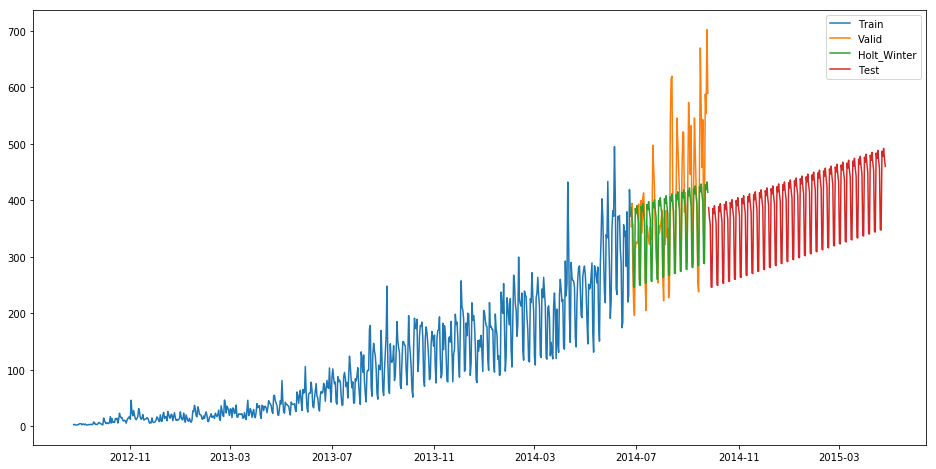

In [33]:
plt.figure(figsize=(16,8))
plt.plot( Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.plot(test['prediction'], label = 'Test')
plt.legend(loc='best')
plt.show()